<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself - with a Neural Network!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to apply Machine Learning in search for the Higgs boson!

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This notebook builds on [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb) in the same folder as this notebook. HZZAnalysis.ipynb loosely follows the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1)

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/HZZ_feynman.png" style="width:40%"></CENTER>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install uproot pandas numpy matplotlib sklearn --user # install required packages

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [1]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

General definitions of fraction of data used, where to access the input files

In [2]:
lumi = 10 # fb-1 # data_A+B+C+D

fraction = 0.03 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

samples to process

In this notebook we only process the signal <span style="color:blue">H->ZZ</span> and the main background <span style="color:red">ZZ</span>, for illustration purposes. You can add data and the Z and ttbar <span style="color:red">backgrounds</span> after if you wish.

In [3]:
samples = {

    'ZZ' : {
        'list' : ['llll']
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep'] # gluon-gluon fusion
    }

}

Define function to get data from files

In [4]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

define function to get cross-section weight

In [5]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate weight of MC event

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

We add functions to return the individual lepton transverse momenta, in GeV

In [7]:
def calc_lep_pt_i(lep_pt,i):
    return lep_pt[i]/1000 # /1000 to go from MeV to GeV

All cuts are defined here

In [8]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

All cuts are implemented here.

In this notebook, we comment out the cut on lepton pt on lines 47-49. This is so that we can optimise this cut later on.

In [9]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path)["mini"] # open the tree called mini
    numevents = uproot.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_n','lep_pt','lep_eta','lep_phi',
                              'lep_E','lep_charge','lep_type', 
                              # add more variables here if you make cuts on them 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                             entrysteps=2500000, # number of events in a batch to process
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)

        # return the individual lepton transverse momenta in GeV
        data['lep_pt_1'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,1)
        data['lep_pt_2'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,2)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts


This is where the processing happens

In [10]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing ZZ samples
	Processing: llll
		 nIn: 16628,	 nOut: 	15740	 in 253.2s
Processing $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ samples
	Processing: ggH125_ZZ4lep
		 nIn: 4941,	 nOut: 	4841	 in 502.1s
Time taken: 755.3s


## Optimisation

Here we define histograms for the variables that we'll look to optimise

In [11]:
lep_pt_2 = { # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':13, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[2] [GeV]', # x-axis label
}

lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}

SoverB_hist_dict = {'lep_pt_2':lep_pt_2,'lep_pt_1':lep_pt_1} 
# add a histogram here if you want it plotted

Here we define a function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

In [12]:
def plot_SoverB(data):
    
    signal = r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bins = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
        signal_weights = data[signal].totalWeight # get the weights of the signal events
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries
        mc_weights = [] # define list to hold the Monte Carlo weights

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                mc_weights = [*mc_weights, *data[s].totalWeight ] # append to the list of Monte Carlo weights

    
    
        # *************
        # Signal and background distributions
        # *************
        main_axes = plt.gca() # get current axes
 
        mc_heights = main_axes.hist(mc_x,bins=bins, color='r', label='Total background',
                                    histtype='step', density=True, weights=mc_weights )
        signal_heights = main_axes.hist(signal_x, bins=bins, color='blue', 
                                        label=signal, histtype='step', density=True,
                                        linestyle='--', weights=signal_weights)
        
        main_axes.set_xlim( left=bins[0], right=bins[-1] ) # set the x-limit of the main axes
        main_axes.set_ylabel('Arbitrary units' ) # write y-axis label for main axes
        main_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        main_axes.legend() # draw the legend
        main_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.93, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.88, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 style='italic',
                 fontsize=8 )  
    
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bins: # loop over bins
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        main_axes = plt.gca() # get current axes
        main_axes.plot( bins[:len(SoverB)], SoverB ) # plot the data points
        main_axes.set_xlim( left=bins[0], right=bins[-1] ) # set the x-limit of the main axes
        main_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        main_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.3, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.23, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 style='italic',
                 fontsize=8 ) 
        
        plt.show() # show S/B plot
    
    return

Here we call our function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

Let's talk through the lep_pt_2 plots.
1. Imagine placing a cut at 7 GeV in the distributions of <span style="color:blue">signal</span> and <span style="color:red">background</span> (1st plot). This means keeping all events above 7 GeV in the <span style="color:blue">signal</span> and <span style="color:red">background</span> histograms. 
2. We then take the ratio of the number of <span style="color:blue">signal</span> events that pass this cut, to the number of <span style="color:red">background</span> events that pass this cut. This gives us a starting value for S/B (2nd plot). 
3. We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more <span style="color:red">background</span> than <span style="color:blue">signal</span>, so S/B increases. 
4. There comes a point around 13 GeV where we start throwing away too much <span style="color:blue">signal</span>, thus S/B starts to decrease. 
5. Our goal is to find the maximum in S/B, and place the cut there.

The same logic applies to lep_pt_1.

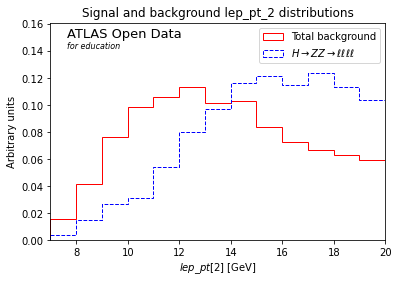

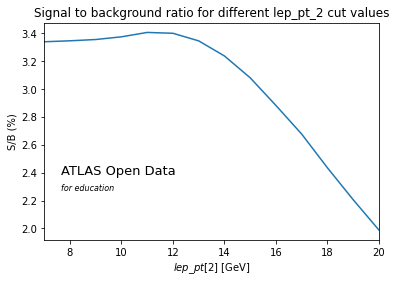

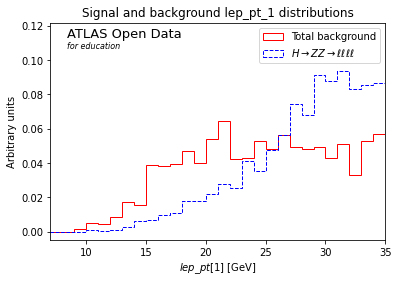

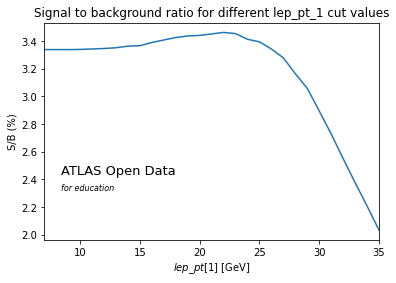

In [13]:
plot_SoverB(data)

## Neural Network

Choose variables for use in the Neural Network

In [14]:
data_for_NN = {} # define empty dictionary to hold dataframes that will be used to train the NN
NN_inputs = ['lep_pt_1','lep_pt_2'] # list of features for Neural Network
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_NN[key] = data[key][NN_inputs].copy()
data_for_NN

{'ZZ':         lep_pt_1   lep_pt_2
 entry                      
 0      61.677957  48.666441
 1      41.498750  18.562252
 2      78.250461  56.973090
 3      26.851668  13.466778
 4      98.566398  74.528453
 ...          ...        ...
 16623  40.231020  14.359087
 16624  71.017078  24.197906
 16625  54.766832  27.539174
 16626  50.042633  35.911793
 16627  35.250531  26.751711
 
 [15740 rows x 2 columns],
 '$H \\rightarrow ZZ \\rightarrow \\ell\\ell\\ell\\ell$':         lep_pt_1   lep_pt_2
 entry                      
 0      41.248570  16.397670
 1      40.307168  16.133789
 2      27.313271  20.035949
 3      27.845740  17.726541
 4      53.367754  25.596689
 ...          ...        ...
 4935   29.323988  28.241137
 4936   58.395027  43.535012
 4937   32.114463  26.019475
 4938   55.594645  22.598514
 4940   36.496094  18.893633
 
 [4841 rows x 2 columns]}

 Organise data ready for the NN

In [15]:
# for sklearn data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_NN[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!=r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_NN[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_NN[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

### The Training and Testing split
One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of <span style="color:orange">X</span> for training and the last 33% for testing. This is particularly important in cases where you load all <span style="color:blue">signal</span> events first and then the <span style="color:red">background</span> events.

Here we split our data into two independent samples. The split is to create a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

In [16]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=492 )

### Data Preprocessing for Neural Network

The neural network in Python may have difficulty converging before the maximum number of iterations allowed if the data is not normalized. Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. Note that you must apply the same scaling to the test set for meaningful results. There are a lot of different methods for normalization of data, we will use the built-in StandardScaler for standardization.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

### Training the Neural Network model
Now it is time to train our model. SciKit Learn makes this incredibly easy, by using estimator objects. In this case we will import our estimator (the Multi-Layer Perceptron Classifier model) from the neural_network library of SciKit-Learn

In [19]:
from sklearn.neural_network import MLPClassifier

Next we create an instance of the model, there are a lot of parameters you can choose to define and customize here, we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose 1 layer with the same number of neurons as there are features in our data set along with 200 max iterations.

In [20]:
hidden_layer_sizes = [len(NN_inputs)] # 1 hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), # define parameters for our multi-layer-perceptron
                    max_iter=200 ) # max number of iterations

Now that the model has been made we can fit the training data to our model, remember that this data has already been processed and scaled:

In [21]:
#print(X_train)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[2], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

You can see the output that shows the default values of the other parameters in the model. We encourage you to play around with them and discover what effects they have on your neural network in Python.

### ROC curve for Neural Network
Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

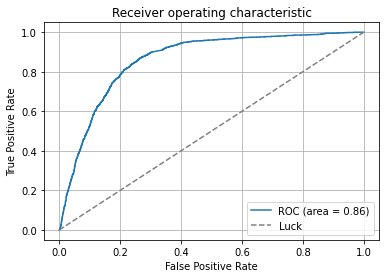

In [22]:
from sklearn.metrics import roc_curve, auc

decisions = mlp.predict_proba(X_test)[:, 1] # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic') # title
plt.legend() # add legend
plt.grid() # add grid

### Neural Network Overtraining Check
Comparing the Neural Network's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The <span style="color:orange">compare_train_test()</span> method will plot the shape of the Neural Network's decision function for each class, as well as overlaying it with the decision function in the training set.

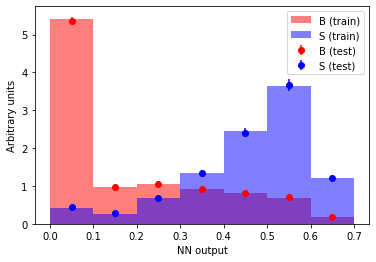

In [23]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
        d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("NN output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    
compare_train_test(mlp, X_train, y_train, X_test, y_test) # call compare_train_test

Here we get the Neural Network's prediction probability for every event that was processed at the begininning (so could be data, <span style="color:blue">signal</span>, <span style="color:red">background</span>...). The higher the probability, the more the Neural Network thinks that event looks like <span style="color:blue">signal</span>.

In [24]:
y_predicted = mlp.predict_proba(X)[:, 1]
y_predicted

array([0.0107522 , 0.54553589, 0.0014868 , ..., 0.47969387, 0.23830476,
       0.61261679])

In this cell we save the Neural Network output to our dataframes.

In [25]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    data[key]['NN_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
    cumulative_events += len(data[key]) # increment counter for total number of events
    print(data[key]['NN_output']) # print the dataframe column NN_output

entry
0        0.010752
1        0.545536
2        0.001487
3        0.405309
4        0.000056
           ...   
16623    0.636642
16624    0.090188
16625    0.157806
16626    0.088247
16627    0.410599
Name: NN_output, Length: 15740, dtype: float64
entry
0       0.609607
1       0.630605
2       0.504280
3       0.480695
4       0.203428
          ...   
4935    0.460028
4936    0.023436
4937    0.479694
4938    0.238305
4940    0.612617
Name: NN_output, Length: 4841, dtype: float64


Here we define parameters to plot the Neural Network output

In [26]:
NN_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':10, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'NN output', # x-axis label
}

SoverB_hist_dict = {'NN_output':NN_output}

Here we call the function defined above to to illustrate the optimum cut value on Neural Network output, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

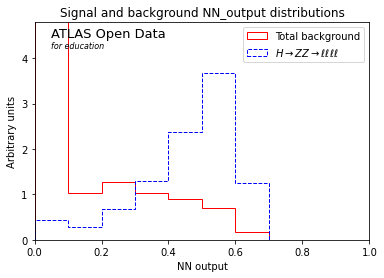

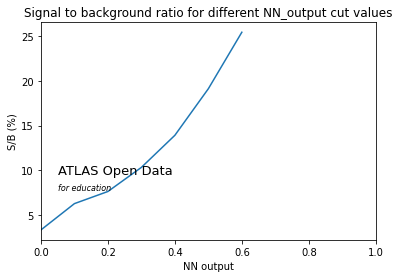

In [27]:
plot_SoverB(data)

Putting everything into a Neural Network means we only have 1 variable to optimise. The <span style="color:blue">signal</span> and <span style="color:red">background</span> distributions are separated much better when looking at Neural Network output, compared to individual variables. Cutting on Neural Network output also achieves much higher S/B values than on individual variables.

Hopefully you've enjoyed this discussion on optimising for <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio, and in particular how a Neural Network can be used to facilitate this.

If you want to go further, there are a number of things you could try: 
* Increase the fraction of events that are processed, at the top of this notebook.
* Add in the other <span style="color:blue">H->ZZ signal</span> samples at the top of this notebook. You can copy them from [HZZAnalysis.ipynb](https://github.com/meevans1/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Try adding them one at a time first, then see how things look with all added.
* Add in the Z and ttbar <span style="color:red">backgrounds</span>. You can copy them from [HZZAnalysis.ipynb](https://github.com/meevans1/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Try adding them separately first, then see how things look with both added.
* Add some more variables into the Neural Network. Add them in one at a time, rather than all at once, because adding a variable could decrease Neural Network performance, due to anti-correlation. For some ideas of variables, you can look at the paper for the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1).
* Add in real data and see whether the Neural Network output distributions in data and MC match.
* Modify some Neural Network hyper-parameters

With each change, keep an eye on the:
* total area under the ROC curve, 
* separation between <span style="color:blue">signal</span> and <span style="color:red">background</span> in the Neural Network output distribution
* S/B scores that can be achieved